## makemore: part 5

In this notebook we will be looking to improve on our previous work where we used a simple network that concatenated the previous n characters to generate the next character. We hit a wall with this approach due to the limit in its complexity. We will now take inspiration from the WaveNet paper and implement a similar network to see if we can improve on our previous results. 

The WaveNet paper can be found here: https://arxiv.org/pdf/1609.03499.pdf

The paper proposed an autoregressive model to generate audio waveforms. So, we will take the same approach and use the same network to generate text.

But first, let's improve and clean up our previous code from part 3.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# read in our data
with open('names.txt') as f:
    words = f.read().splitlines()

print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [9]:
# create a dictionary of all the characters in our dataset
chars = set(''.join(words))
ctoi = {c: i+1 for i, c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i: c for c, i in ctoi.items()}
vocab_size = len(itoc)
print(itoc)
print(vocab_size)

{1: 'a', 2: 'l', 3: 'x', 4: 'f', 5: 'o', 6: 't', 7: 'w', 8: 'y', 9: 'p', 10: 'b', 11: 'u', 12: 'j', 13: 'd', 14: 'h', 15: 'e', 16: 'g', 17: 'z', 18: 'r', 19: 's', 20: 'c', 21: 'q', 22: 'k', 23: 'i', 24: 'n', 25: 'v', 26: 'm', 0: '.'}
27


In [10]:
import random

random.seed(42) # set the random seed for reproducibility
random.shuffle(words)

In [11]:
block_size = 3

def split_dataset(train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + test_size == 1, 'train_size + val_size + test_size must equal 1'
    train_idx = int(len(words) * train_size)
    val_idx = int(len(words) * (train_size+val_size))
    return words[:train_idx], words[train_idx:val_idx], words[val_idx:]

def build_dataset(dataset, n=3):
    X, Y = [], []
    for word in dataset:
        context = [0] * n
        for c in word + '.':
            X.append(context)
            Y.append(ctoi[c])
            context = context[1:] + [ctoi[c]]

    return torch.tensor(X), torch.tensor(Y)

# generate out datasets
train_dataset, val_dataset, test_dataset = split_dataset()
Xtr, Ytr = build_dataset(train_dataset, n=block_size)
Xdev, Ydev = build_dataset(val_dataset, n=block_size)
Xte, Yte = build_dataset(test_dataset, n=block_size)

In [12]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itoc[ix.item()] for ix in x), '-->', itoc[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


We previously had classes for a Linear, BatchNorm1d, and a Tanh Layer. However, we also need an Embedding, and Flatten class. We can also introduce a Sequential class to make it easier to create our network. This will be similar to the Sequential class in PyTorch which acts a container.

In [41]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # trainable params
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # running statistic means
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            batch_mean = x.mean(0, keepdim=True)
            batch_var = x.var(0, keepdim=True, unbiased=True)
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var

        # normalize batch
        self.out = self.gain * ((x - batch_mean) / torch.sqrt(batch_var + self.eps)) + self.bias

        if self.training:
            # update running statistics
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]
    
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [48]:
@torch.no_grad()
def split_loss(model, split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = torch.nn.functional.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.3f}')

In [42]:
torch.manual_seed(42)

In [43]:
n_embed = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embed), Flatten(),
    Linear(n_embed*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(f'{sum(p.nelement() for p in parameters)} trainable parameters')

for p in parameters:
    p.requires_grad = True

12297 trainable parameters


Now using the new setup, we need to fix the forward pass of our network. We also need to fix the plotting of the loss function. Currently, we are plotting the loss at every step, instead it would be better to plot the average loss over a number of steps. This will make it easier to see the trend of the loss function.

In [44]:
max_steps = 200000
batch_size = 32
train_losses = []

for step in range(max_steps):

    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    x = Xb

    logits = model(x)

    loss = F.cross_entropy(logits, Yb) # compute loss

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 150000 else 0.01
    for param in parameters:
        param.data -= lr * param.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {loss:.4f}')

    train_losses.append(loss.item())

      0/ 200000: train loss 3.3225
  10000/ 200000: train loss 2.3086
  20000/ 200000: train loss 2.3685
  30000/ 200000: train loss 1.9535
  40000/ 200000: train loss 2.2853
  50000/ 200000: train loss 2.2123
  60000/ 200000: train loss 1.9856
  70000/ 200000: train loss 1.9415
  80000/ 200000: train loss 2.7265
  90000/ 200000: train loss 2.0473
 100000/ 200000: train loss 2.3309
 110000/ 200000: train loss 1.6408
 120000/ 200000: train loss 2.1397
 130000/ 200000: train loss 2.2131
 140000/ 200000: train loss 2.1660
 150000/ 200000: train loss 1.9526
 160000/ 200000: train loss 1.8818
 170000/ 200000: train loss 2.2094
 180000/ 200000: train loss 2.0724
 190000/ 200000: train loss 2.2456


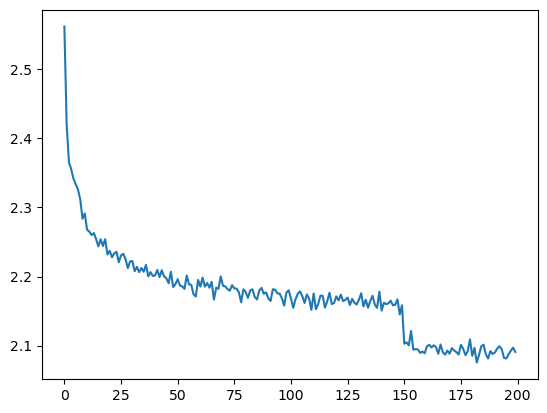

In [32]:
plt.plot(torch.tensor(train_losses).view(-1, 1000).mean(1));

In [45]:
for layer in model.layers:
    layer.training = False

In [50]:
split_loss(model, 'train')
split_loss(model, 'val')

train loss: 2.061
val loss: 2.107


Now that we have our baseline performance, let's see what we get when we simply increase the context size to 8.

In [51]:
block_size = 8

Xtr, Ytr = build_dataset(train_dataset, n=block_size)
Xdev, Ydev = build_dataset(val_dataset, n=block_size)
Xte, Yte = build_dataset(test_dataset, n=block_size)

In [66]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itoc[i.item()] for i in x), '-->', itoc[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [67]:
n_embed = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embed), Flatten(),
    Linear(n_embed*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(f'{sum(p.nelement() for p in parameters)} trainable parameters')

for p in parameters:
    p.requires_grad = True

22297 trainable parameters


In [68]:
max_steps = 200000
batch_size = 32
train_losses = []

for step in range(max_steps):

    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    x = Xb

    logits = model(x)

    loss = F.cross_entropy(logits, Yb) # compute loss

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 150000 else 0.01
    for param in parameters:
        param.data -= lr * param.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {loss:.4f}')

    train_losses.append(loss.item())

      0/ 200000: train loss 3.2901
  10000/ 200000: train loss 2.3623
  20000/ 200000: train loss 2.3460
  30000/ 200000: train loss 1.8886
  40000/ 200000: train loss 2.1189
  50000/ 200000: train loss 2.0927
  60000/ 200000: train loss 1.9501
  70000/ 200000: train loss 2.2514
  80000/ 200000: train loss 1.5391
  90000/ 200000: train loss 1.7722
 100000/ 200000: train loss 1.6624
 110000/ 200000: train loss 2.5347
 120000/ 200000: train loss 2.2462
 130000/ 200000: train loss 2.1772
 140000/ 200000: train loss 1.9713
 150000/ 200000: train loss 2.2761
 160000/ 200000: train loss 1.6839
 170000/ 200000: train loss 1.7229
 180000/ 200000: train loss 2.0824
 190000/ 200000: train loss 1.9093


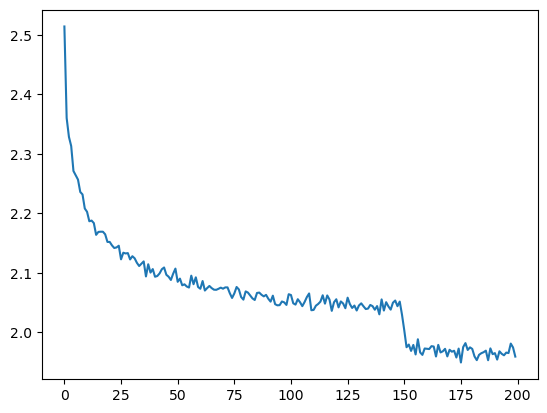

In [69]:
plt.plot(torch.tensor(train_losses).view(-1, 1000).mean(1));

In [70]:
for layer in model.layers:
    layer.training = False

In [71]:
split_loss(model, 'train')
split_loss(model, 'val')

train loss: 1.922
val loss: 2.028


So we see an improvement in the loss and model just by increasing the context size. However, the main issue appears to be that we are squashing too much information together at once and using it to predict the next character. This is where the WaveNet paper offers a different approach. Instead of squashing all the information together at once, we can attempt to squash it together in a more controlled manner. This is done by squashing 2 characters together to obtain a sort of bigram representation. Then we can squash 2 bigram representations together to obtain a quadgram representation. We can continue this process until we have a representation of the entire sequence, and use that to predict the next character.

To do this we need to modify our Flatten layer or create a new layer that will offer this control. We will create a new layer called a Concatenate layer, this will allow us to concatenate the previous n characters together. We also need to modify the BatchNorm1d layer to allow for finding the batch statistics over more than one dimension.

In [101]:
class Concatenate:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, L, C = x.shape
        self.out = x.view(B, L//self.n, C*self.n)
        if L//self.n == 1:
            self.out = self.out.squeeze(1)

        return self.out
    
    def parameters(self):
        return []
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # trainable params
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # running statistic means
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):            
        if self.training:
            if x.ndim == 2:
                dim = (0)
            elif x.ndim == 3:
                dim = (0, 1)
                
            batch_mean = x.mean(dim, keepdim=True)
            batch_var = x.var(dim, keepdim=True, unbiased=True)
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var

        # normalize batch
        self.out = self.gain * ((x - batch_mean) / torch.sqrt(batch_var + self.eps)) + self.bias

        if self.training:
            # update running statistics
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]

We can now build our network using the new layer implementations. We will also adjust the n_hidden parameter to get the same number of parameters as our previous network. This way we can offer a comparison betweent the two networks.

In [102]:
n_embed = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embed),
    Concatenate(2), Linear(n_embed*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Concatenate(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Concatenate(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(f'{sum(p.nelement() for p in parameters)} trainable parameters')

for p in parameters:
    p.requires_grad = True

22397 trainable parameters


In [103]:
max_steps = 200000
batch_size = 32
train_losses = []

for step in range(max_steps):

    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]

    # forward pass
    x = Xb

    logits = model(x)

    loss = F.cross_entropy(logits, Yb) # compute loss

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 150000 else 0.01
    for param in parameters:
        param.data -= lr * param.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {loss:.4f}')

    train_losses.append(loss.item())

      0/ 200000: train loss 3.3167
  10000/ 200000: train loss 2.0439
  20000/ 200000: train loss 1.9957
  30000/ 200000: train loss 1.9609
  40000/ 200000: train loss 1.9019
  50000/ 200000: train loss 1.8457
  60000/ 200000: train loss 2.1169
  70000/ 200000: train loss 2.1033
  80000/ 200000: train loss 2.0373
  90000/ 200000: train loss 2.0720
 100000/ 200000: train loss 2.0810
 110000/ 200000: train loss 2.1349
 120000/ 200000: train loss 1.9854
 130000/ 200000: train loss 2.0554
 140000/ 200000: train loss 1.8688
 150000/ 200000: train loss 1.8602
 160000/ 200000: train loss 1.9268
 170000/ 200000: train loss 1.8692
 180000/ 200000: train loss 2.1043
 190000/ 200000: train loss 1.5575


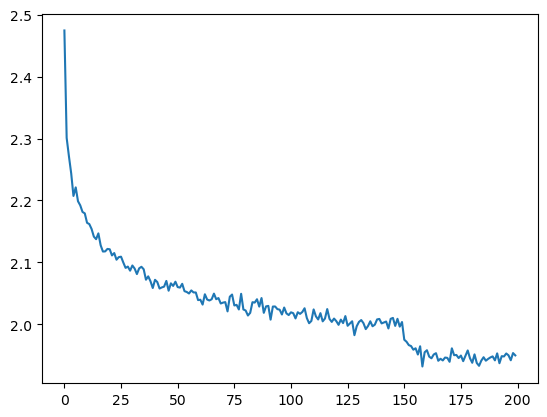

In [104]:
plt.plot(torch.tensor(train_losses).view(-1, 1000).mean(1));

In [105]:
for layer in model.layers:
    layer.training = False

In [106]:
split_loss(model, 'train')
split_loss(model, 'val')

train loss: 1.910
val loss: 2.024


### performance log

- original (3 character context, 200 hidden neurons, 12K params): train: 2.061, val: 2.107
- context: 3 -> 8 (22K params): train: 1.922, val: 2.028
- flat -> hierarchical (22K params): train: 1.910, val: 2.024

In [ ]:
for _ in range(20):
    context = [0]*3
    word = ''
    while True:
        logits = model(x)
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, num_samples=1).item()
        if ix == 0:
            break
        word += itoc[ix]
        context = context[1:] + [ix]
    print(word)

# Exercises
- Play with hyperparameters to see if you can improve the performance of the network.
- Try to implement hierarchical structure using dilated causal convolutions instead of the Concatenate layer.
- Try to implement more complicated WaveNet architecture with residual connections and gated activations.